In [1]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle
import matplotlib.ticker as plticker
plt.rcParams["figure.figsize"] = (15,7)
from numpy.lib.scimath import sqrt as csqrt

os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py') 


## Calculos Teoricos

Ac index change = 0.000712261337882327


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


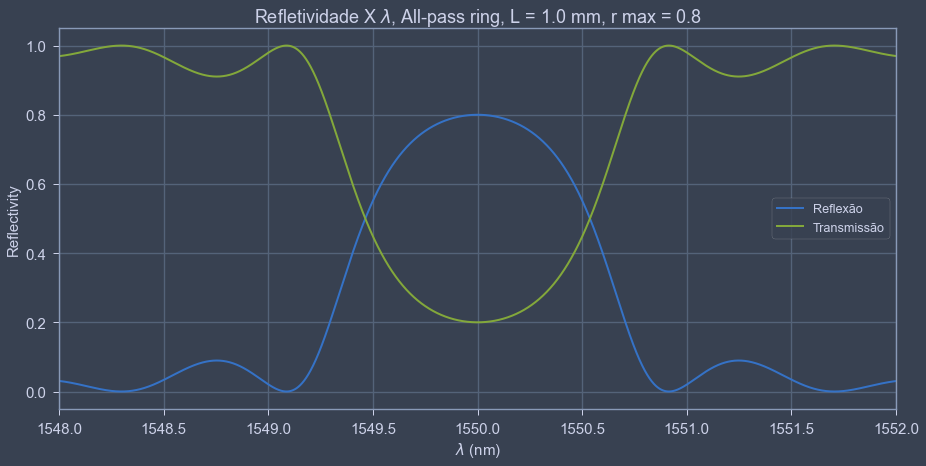

In [2]:
# Constantes

c = 299792458
neff = 1.447
comprimento = np.linspace(1548*1e-9,1552*1e-9,100000)
# Parametros

lambda_ressonancia = 1550e-9
L = 1e-3
rmax = 0.8

# Calculos
sigma_base = 0 # dc coupling
detuning = 2*np.pi*neff*(1/comprimento - 1/lambda_ressonancia)

sigma = sigma_base + detuning
kappa = np.arctanh(np.sqrt(rmax))/L

#vindice = kappa*lambda_ressonancia/np.pi
#kappa = np.pi*vindice/comprimento
reflexao = (np.sinh(L*csqrt((kappa**2-sigma**2)))**2)/((np.cosh(L*csqrt((kappa**2-sigma**2)))**2) - ((sigma**2)/(kappa**2)))
print('Ac index change = {}'.format(kappa*lambda_ressonancia/np.pi))


plt.plot(comprimento*1e9,reflexao,linewidth=2)
plt.plot(comprimento*1e9,1-reflexao,linewidth=2)
plt.xlim(1548,1552)
plt.xlabel(r'$\lambda$ (nm)',fontsize =15)
plt.ylabel(r'Reflectivity',fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.title(r'Refletividade X $\lambda$'', All-pass ring, L = {} mm, r max = {}'.format(L*1e3,rmax),fontsize =18)
plt.legend(['Reflexão','Transmissão'])


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


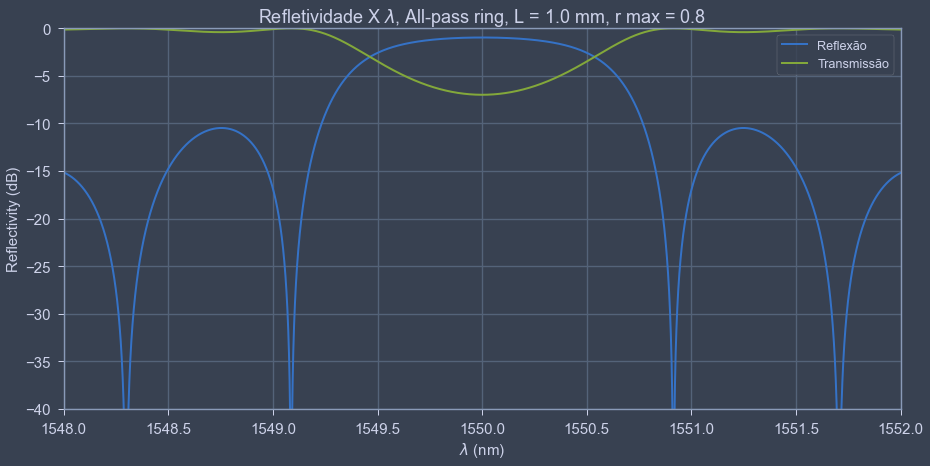

In [3]:
plt.plot(comprimento*1e9,10*np.log10(reflexao),linewidth=2)
plt.plot(comprimento*1e9,10*np.log10(1-reflexao),linewidth=2)
plt.xlim(1548,1552)
plt.ylim(-40,0)
plt.xlabel(r'$\lambda$ (nm)',fontsize =15)
plt.ylabel(r'Reflectivity (dB)',fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.title(r'Refletividade X $\lambda$'', All-pass ring, L = {} mm, r max = {}'.format(L*1e3,rmax),fontsize =18)
plt.legend(['Reflexão','Transmissão'])


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


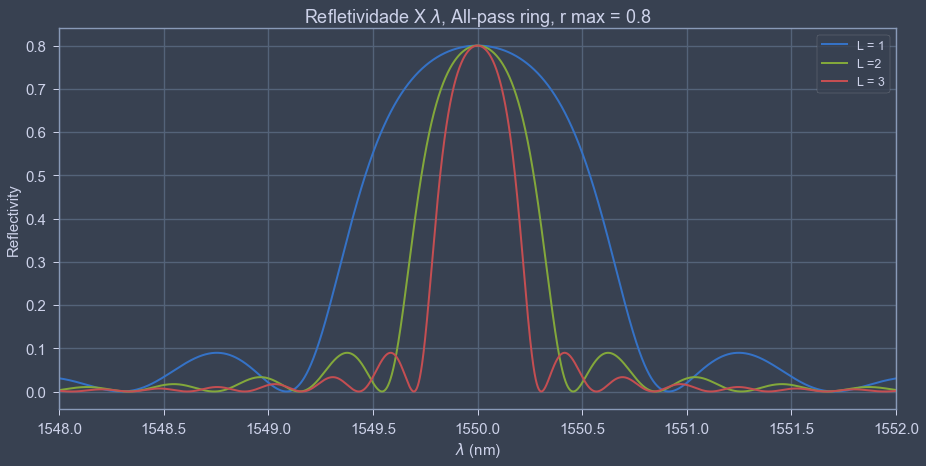

In [28]:
# Constantes

c = 299792458
neff = 1.447
comprimento = np.linspace(1548*1e-9,1552*1e-9,100000)
# Parametros

lambda_ressonancia = 1550e-9
L = 1e-3
rmax = 0.8

# Calculos
sigma_base = 0 # dc coupling
detuning = 2*np.pi*neff*(1/comprimento - 1/lambda_ressonancia)

sigma = sigma_base + detuning
kappa = np.arctanh(np.sqrt(rmax))/L

#vindice = kappa*lambda_ressonancia/np.pi
#kappa = np.pi*vindice/comprimento
reflexao1 = (np.sinh(L*csqrt((kappa**2-sigma**2)))**2)/((np.cosh(L*csqrt((kappa**2-sigma**2)))**2) - ((sigma**2)/(kappa**2)))

lambda_ressonancia = 1550e-9
L = 2e-3
rmax = 0.8

# Calculos
sigma_base = 0 # dc coupling
detuning = 2*np.pi*neff*(1/comprimento - 1/lambda_ressonancia)

sigma = sigma_base + detuning
kappa = np.arctanh(np.sqrt(rmax))/L

#vindice = kappa*lambda_ressonancia/np.pi
#kappa = np.pi*vindice/comprimento
reflexao2 = (np.sinh(L*csqrt((kappa**2-sigma**2)))**2)/((np.cosh(L*csqrt((kappa**2-sigma**2)))**2) - ((sigma**2)/(kappa**2)))

lambda_ressonancia = 1550e-9
L = 3e-3
rmax = 0.8

# Calculos
sigma_base = 0 # dc coupling
detuning = 2*np.pi*neff*(1/comprimento - 1/lambda_ressonancia)

sigma = sigma_base + detuning
kappa = np.arctanh(np.sqrt(rmax))/L

#vindice = kappa*lambda_ressonancia/np.pi
#kappa = np.pi*vindice/comprimento
reflexao3 = (np.sinh(L*csqrt((kappa**2-sigma**2)))**2)/((np.cosh(L*csqrt((kappa**2-sigma**2)))**2) - ((sigma**2)/(kappa**2)))

plt.plot(comprimento*1e9,reflexao1,linewidth=2)
plt.plot(comprimento*1e9,reflexao2,linewidth=2)
plt.plot(comprimento*1e9,reflexao3,linewidth=2)


#plt.plot(comprimento*1e9,10*np.log10(reflexao1),linewidth=2)
#plt.plot(comprimento*1e9,10*np.log10(reflexao2),linewidth=2)
#plt.plot(comprimento*1e9,10*np.log10(reflexao3),linewidth=2)
#plt.ylim(-40,0)
plt.xlim(1548,1552)
plt.xlabel(r'$\lambda$ (nm)',fontsize =15)
plt.ylabel(r'Reflectivity',fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.title(r'Refletividade X $\lambda$'', All-pass ring, r max = 0.8'.format(L*1e3),fontsize =18)
plt.legend(['L = 1', 'L =2', 'L = 3'])


## Interconnect

In [4]:
inter = lumapi.INTERCONNECT(filename='TheoricSimulations.icp')

dict_keys(['wavelength', 'frequency', 'TE gain (dB)', 'Lumerical_dataset'])


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


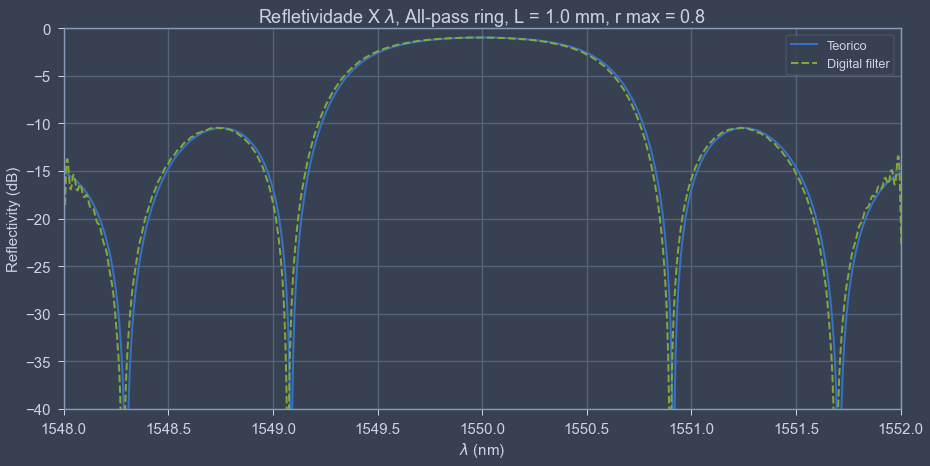

In [18]:
reflexaointer = inter.getresult('ONA_3','input 1/mode 1/gain')
transmissaointer = inter.getresult('ONA_1','input 2/mode 1/gain')
print(reflexaointer.keys())
plt.plot(comprimento*1e9,10*np.log10(reflexao),linewidth=2)
plt.plot(reflexaointer['wavelength']*1e9,reflexaointer['TE gain (dB)'],linewidth=2,linestyle='--')

#plt.plot(transmissaointer['wavelength']*1e9,transmissaointer['TE gain (dB)'])

plt.xlim(1548,1552)
plt.ylim(-40,0)
plt.xlabel(r'$\lambda$ (nm)',fontsize =15)
plt.ylabel(r'Reflectivity (dB)',fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.title(r'Refletividade X $\lambda$'', All-pass ring, L = {} mm, r max = {}'.format(L*1e3,rmax),fontsize =18)
plt.legend(['Teorico','Digital filter'])